In [59]:
# sparsity vs accuracy

In [60]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
import time
import matplotlib.pyplot as plt
import random
from torch.optim import SGD
import torch.nn as nn

In [61]:
model_org = models.vgg19(weights='DEFAULT')

In [62]:
model_org

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [63]:
sparsities = torch.arange(0.0, 1.0, 0.1)
accuracies = []

In [64]:
transform = transforms.Compose([
    transforms.Resize((255,255)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [65]:
data_folder = 'imagenet-mini/val'
data_dataset = datasets.ImageFolder(data_folder, transform=transform)

def get_random_images(n=500):
    num_samples = n
    indices = random.sample(range(len(data_dataset)), num_samples)
    subset_dataset = Subset(data_dataset, indices)
    return DataLoader(subset_dataset, batch_size=32, shuffle=True)

In [66]:
def replace_layers(features, layer_idx, replace_indices, new_layers):
    new_features = []
    for i, layer in enumerate(features):
        if i in replace_indices:
            new_features.append(new_layers[replace_indices.index(i)])
        else:
            new_features.append(layer)
    return torch.nn.Sequential(*new_features)

In [67]:
import torch
import numpy as np

def prune_conv_layer(model, layer_index, filter_index):
    # Extract the target Conv2D layer
    _, conv = list(model.features._modules.items())[layer_index]
    next_conv = None
    offset = 1

    # Find the next Conv2D layer if it exists
    while layer_index + offset < len(model.features._modules.items()):
        res = list(model.features._modules.items())[layer_index + offset]
        if isinstance(res[1], torch.nn.Conv2d):
            next_name, next_conv = res
            break
        offset += 1

    # Create a new Conv2D layer with one fewer filter
    new_conv = torch.nn.Conv2d(
        in_channels=conv.in_channels,
        out_channels=conv.out_channels - 1,
        kernel_size=conv.kernel_size,
        stride=conv.stride,
        padding=conv.padding,
        dilation=conv.dilation,
        groups=conv.groups,
        bias=(conv.bias is not None),
    )

    # Copy old weights and prune one filter
    old_weights = conv.weight.data.cpu().numpy()
    new_weights = new_conv.weight.data.cpu().numpy()

    # Copy weights except for the pruned filter
    new_weights[:filter_index] = old_weights[:filter_index]
    new_weights[filter_index:] = old_weights[filter_index + 1:]
    new_conv.weight.data = torch.from_numpy(new_weights).to('mps')

    # Handle biases
    if conv.bias is not None:
        bias_numpy = conv.bias.data.cpu().numpy()
        new_bias = np.delete(bias_numpy, filter_index)
        new_conv.bias.data = torch.from_numpy(new_bias).to('mps')

    # Handle the next Conv2D layer if it exists
    if next_conv is not None:
        next_new_conv = torch.nn.Conv2d(
            in_channels=next_conv.in_channels - 1,
            out_channels=next_conv.out_channels,
            kernel_size=next_conv.kernel_size,
            stride=next_conv.stride,
            padding=next_conv.padding,
            dilation=next_conv.dilation,
            groups=next_conv.groups,
            bias=(next_conv.bias is not None),
        )

        old_weights = next_conv.weight.data.cpu().numpy()
        new_weights = next_new_conv.weight.data.cpu().numpy()

        # Copy weights excluding the pruned filter
        new_weights[:, :filter_index] = old_weights[:, :filter_index]
        new_weights[:, filter_index:] = old_weights[:, filter_index + 1:]

        next_new_conv.weight.data = torch.from_numpy(new_weights).to('mps')
        next_new_conv.bias.data = next_conv.bias.data if next_conv.bias is not None else None

        # Replace both layers
        model.features[layer_index] = new_conv
        model.features[layer_index + offset] = next_new_conv
    else:
        # Replace only the current layer
        model.features[layer_index] = new_conv

        # Handle the first linear layer in the classifier
        layer_index = 0
        old_linear_layer = None

        for i, module in enumerate(model.classifier):
            if isinstance(module, torch.nn.Linear):
                old_linear_layer = module
                layer_index = i
                break

        if old_linear_layer is None:
            raise ValueError("No linear layer found in classifier")

        params_per_input_channel = old_linear_layer.in_features // conv.out_channels

        # Create a new Linear layer with fewer input features
        new_linear_layer = torch.nn.Linear(
            old_linear_layer.in_features - params_per_input_channel,
            old_linear_layer.out_features,
        )

        # Copy weights excluding the pruned parameters
        old_weights = old_linear_layer.weight.data.cpu().numpy()
        new_weights = new_linear_layer.weight.data.cpu().numpy()

        new_weights[:, :filter_index * params_per_input_channel] = \
            old_weights[:, :filter_index * params_per_input_channel]

        new_weights[:, filter_index * params_per_input_channel:] = \
            old_weights[:, (filter_index + 1) * params_per_input_channel:]

        new_linear_layer.weight.data = torch.from_numpy(new_weights).to('mps')
        new_linear_layer.bias.data = old_linear_layer.bias.data

        # Replace the linear layer
        model.classifier[layer_index] = new_linear_layer

    return model

In [68]:
class ComprehensiveVGGPruner:
    def __init__(self, model, prune_percentage=0.5):
        """
        Initialize the pruner with a VGG model and desired pruning percentage.
        
        Args:
            model: The VGG16 model to prune
            prune_percentage: Percentage of filters to remove from each layer (0.0 to 1.0)
        """
        self.model = model
        self.prune_percentage = prune_percentage
        self.conv_layers = self._get_conv_layer_indices()
        
    def _get_conv_layer_indices(self):
        # sourcery skip: inline-immediately-returned-variable, list-comprehension
        """Find all convolutional layer indices in the model."""
        conv_indices = []
        for i, layer in enumerate(self.model.features):
            if isinstance(layer, torch.nn.Conv2d):
                conv_indices.append(i)
        return conv_indices
    
    def _calculate_filters_per_layer(self):
        """Calculate how many filters to remove from each layer."""
        filters_to_prune = {}
        for layer_idx in self.conv_layers:
            layer = list(self.model.features._modules.items())[layer_idx][1]
            n_filters = layer.out_channels
            n_to_prune = int(n_filters * self.prune_percentage)
            # Ensure we keep at least 2 filters per layer
            n_to_prune = min(n_to_prune, n_filters - 2)
            filters_to_prune[layer_idx] = n_to_prune
        return filters_to_prune
    
    def prune_all_layers(self):
        """Prune all convolutional layers in the network."""
        # print("Starting comprehensive pruning of VGG16...")

        # Calculate number of filters to remove per layer
        filters_to_prune = self._calculate_filters_per_layer()

        # Prune each layer from last to first
        # We go backwards because earlier layer changes affect later layers
        for layer_idx in reversed(self.conv_layers):
            n_filters = filters_to_prune[layer_idx]
            # print(f"\nPruning layer {layer_idx}")
            # print(f"Original filters: {self.model.features[layer_idx].out_channels}")
            # print(f"Removing {n_filters} filters")

            # Remove filters one by one
            for _ in range(n_filters):
                # Always remove the first filter as the indices shift after each removal
                self.model = prune_conv_layer(self.model, layer_idx, 0)

            # print(f"Remaining filters: {self.model.features[layer_idx].out_channels}")

        print("Pruning completed!")
        return self.model

def prune_vgg16_comprehensive(prune_percentage):
    # Load a pretrained VGG16 model
    model = model_org

    # Create pruner and perform pruning
    pruner = ComprehensiveVGGPruner(model, prune_percentage)
    return pruner.prune_all_layers()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def calculate_parameter_reduction(original_model, pruned_model):
    if not hasattr(original_model, 'parameters') or not hasattr(pruned_model, 'parameters'):
        raise ValueError("Inputs must be valid PyTorch models")

    original_params = sum(p.numel() for p in original_model.parameters() if p.requires_grad)
    pruned_params = sum(p.numel() for p in pruned_model.parameters() if p.requires_grad)

    if original_params == 0:
        raise ValueError("Original model has no trainable parameters")

    return ((original_params - pruned_params) / original_params) * 100


def calculate_flops(model, input_size=(1, 3, 224, 224)):
    model.eval()
    
    # Create custom forward hooks that don't rely on total_ops attribute
    def count_conv2d(m, x, y):
        x = x[0]
        cin = m.in_channels
        cout = m.out_channels
        kh, kw = m.kernel_size
        batch_size = x.size()[0]
        out_h = y.size(2)
        out_w = y.size(3)
        
        # ops: multiply-add is counted as 1 operation
        kernel_ops = kh * kw * cin
        bias_ops = 1 if m.bias is not None else 0
        ops_per_element = kernel_ops + bias_ops
        
        # total ops
        total_ops = batch_size * cout * out_h * out_w * ops_per_element
        return total_ops
    
    def count_linear(m, x, y):
        x = x[0]
        total_ops = x.size(0) * m.in_features * m.out_features
        if m.bias is not None:
            total_ops += x.size(0) * m.out_features
        return total_ops

    # Register hooks
    hooks = []
    total_ops = 0
    
    def register_hooks(module):
        if isinstance(module, torch.nn.Conv2d):
            hook = module.register_forward_hook(
                lambda m, x, y: setattr(m, 'total_ops', count_conv2d(m, x, y)))
            hooks.append(hook)
        elif isinstance(module, torch.nn.Linear):
            hook = module.register_forward_hook(
                lambda m, x, y: setattr(m, 'total_ops', count_linear(m, x, y)))
            hooks.append(hook)
    
    model.apply(register_hooks)
    
    # Perform forward pass
    input = torch.randn(input_size).to('mps')
    model(input)
    
    # Sum up the total operations
    for module in model.modules():
        if hasattr(module, 'total_ops'):
            total_ops += module.total_ops
    
    # Remove hooks
    for hook in hooks:
        hook.remove()
    
    return total_ops

def fine_tuning(model):
    model = model.to('mps')
    model.train()
    optimizer = SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    for _ in range(3):
        running_loss = 0.0
        for data in get_random_images(n=300):
            inputs, labels = data
            inputs = inputs.to('mps')
            labels = labels.to('mps')
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        # print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")
    print("Finished fine-tuning!")
    return model

def comp_accuracy(model):
    model.eval()
    model = model.to('mps')
    correct = 0
    total = 0
    comp_time = 0
    with torch.no_grad():
        for data in get_random_images(n=1000):
            images, labels = data
            images = images.to('mps')
            labels = labels.to('mps')
            t1 = time.time()
            outputs = model(images)
            t2 = time.time()
            comp_time += (t2 - t1)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return [(correct / total)*100 , comp_time]
    
comp_times = []
accuracies = []
g_flops = []    

if __name__ == "__main__":
    sparsities = torch.arange(0.0, 1.1, 0.1)
    org_accuracy = None
    for sparsity in sparsities:
        print(f"Pruning {model_org.__class__.__name__} with sparsity {sparsity:.2f}")
        pruned_vgg = prune_vgg16_comprehensive(prune_percentage=sparsity)
        pruned_vgg = fine_tuning(pruned_vgg)
        torch.save(pruned_vgg, f'pruned_models/pruned_vgg_{sparsity:.2f}.pth')
        accuracy, comp_time = comp_accuracy(pruned_vgg)
        flops = calculate_flops(pruned_vgg)
        flops = flops / 1e9
        accuracies.append(accuracy)
        comp_times.append(comp_time)
        g_flops.append(flops)
        if sparsity == 0.0:
            org_accuracy = accuracy
            print(org_accuracy)
        # param_reduction = calculate_parameter_reduction(model_org, pruned_vgg)
        param_org, param_pruned = count_parameters(model_org), count_parameters(pruned_vgg)
        print(f"Original Parameters: {param_org}, Pruned Parameters: {param_pruned}")
        # param_reduction = ((param_org - param_pruned) / param_org) * 100
        model_size = sum(param.numel() * param.element_size() for param in pruned_vgg.parameters()) / (1024 * 1024)
        print(f"Sparsity: {sparsity:.2f}, Accuracy Reduction: {org_accuracy - accuracy:.2f}%, Model Size: {model_size:.2f} MB, FLOPs: {flops:.2f} GFLOPs, Comp Time: {comp_time:.6f} s")

Pruning VGG with sparsity 0.00
Pruning completed!
Finished fine-tuning!
64.0
Original Parameters: 143667240, Pruned Parameters: 143667240
Sparsity: 0.00, Accuracy Reduction: 0.00%, Model Size: 548.05 MB, FLOPs: 19.65 GFLOPs, Comp Time: 0.083731 s
Pruning VGG with sparsity 0.10
Pruning completed!
Finished fine-tuning!
Original Parameters: 129654563, Pruned Parameters: 129654563
Sparsity: 0.10, Accuracy Reduction: 14.60%, Model Size: 494.59 MB, FLOPs: 16.03 GFLOPs, Comp Time: 0.084954 s
Pruning VGG with sparsity 0.20
Pruning completed!
Finished fine-tuning!
Original Parameters: 105355934, Pruned Parameters: 105355934
Sparsity: 0.20, Accuracy Reduction: 58.70%, Model Size: 401.90 MB, FLOPs: 10.35 GFLOPs, Comp Time: 0.083191 s
Pruning VGG with sparsity 0.30
Pruning completed!
Finished fine-tuning!
Original Parameters: 77999685, Pruned Parameters: 77999685
Sparsity: 0.30, Accuracy Reduction: 63.90%, Model Size: 297.55 MB, FLOPs: 5.16 GFLOPs, Comp Time: 0.073930 s
Pruning VGG with sparsity 0

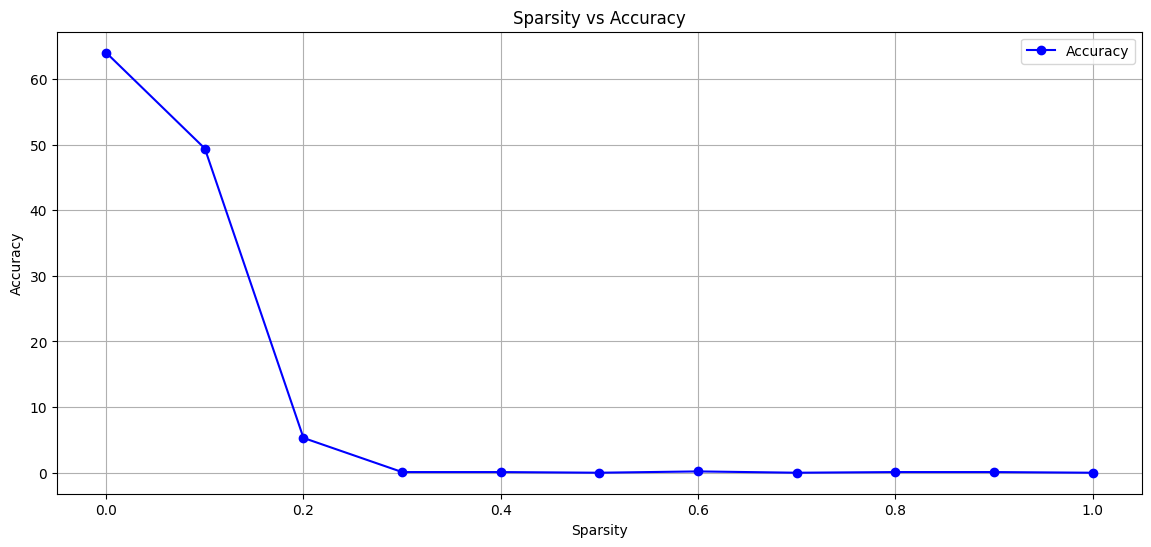

In [69]:
plt.figure(figsize=(14, 6))
plt.plot(sparsities, accuracies, color = 'blue', marker = 'o', label = 'Accuracy')
plt.grid()
plt.xlabel('Sparsity')
plt.ylabel('Accuracy')
plt.title('Sparsity vs Accuracy')
plt.legend()
plt.show()

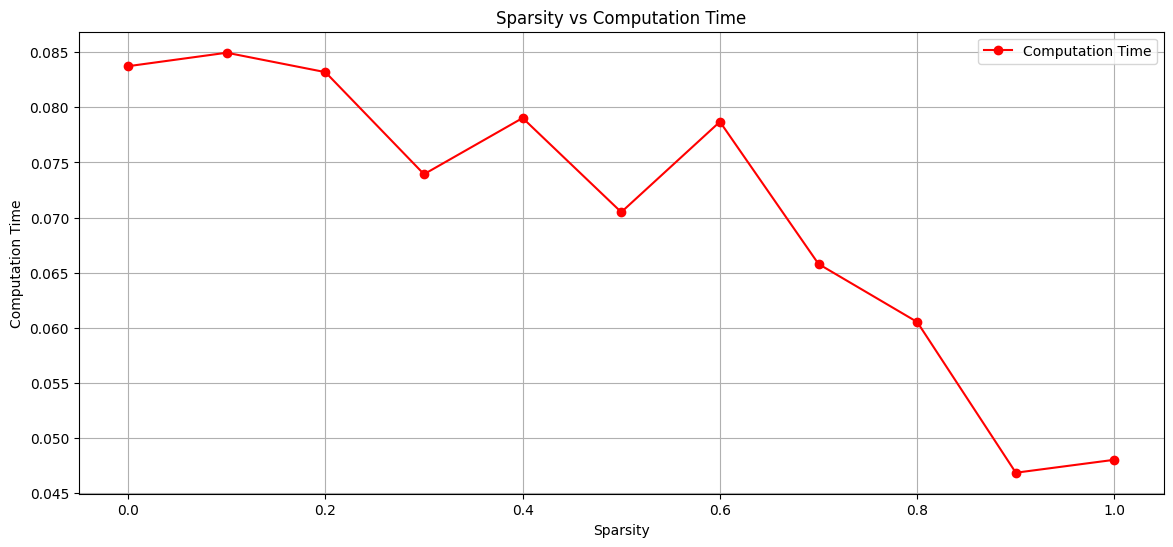

In [70]:
plt.figure(figsize=(14, 6))
plt.plot(sparsities, comp_times, label='Computation Time', color='r', marker='o')
plt.grid()
plt.xlabel('Sparsity')
plt.ylabel('Computation Time')
plt.title('Sparsity vs Computation Time')
plt.legend()
plt.show()

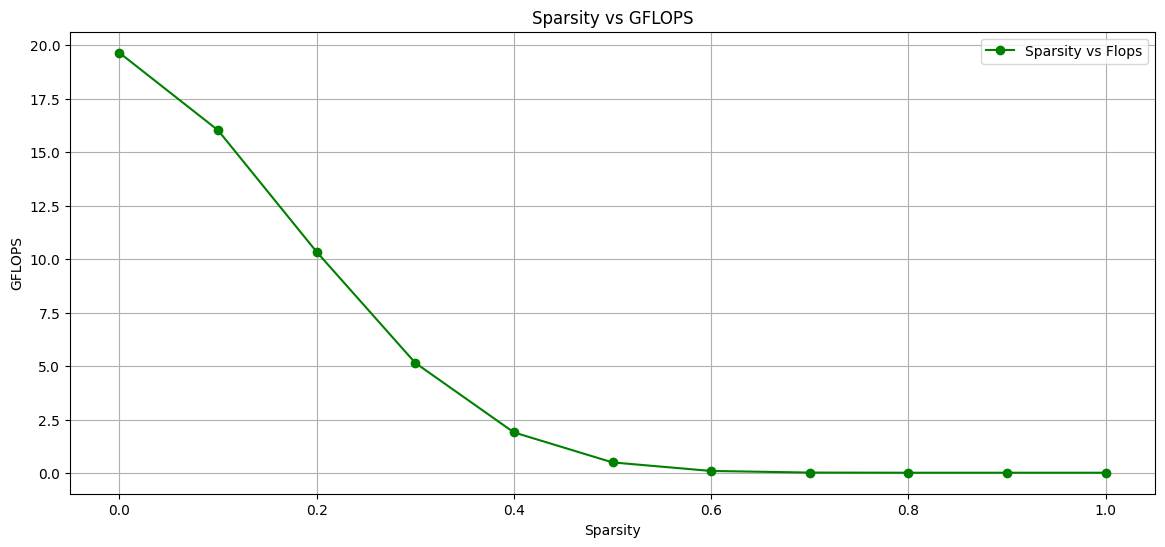

In [71]:
plt.figure(figsize=(14, 6))
plt.plot(sparsities, g_flops, label='Sparsity vs Flops', color='g', marker='o')
plt.grid()
plt.xlabel('Sparsity')
plt.ylabel('GFLOPS')
plt.title('Sparsity vs GFLOPS')
plt.legend()
plt.show()